# Regression Models

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Load the dataset
df = pd.read_csv('flight.csv')

## Exploratory Data Analysis (EDA)

### Data Overview

In [2]:
print(df.head())
print(df.info())
print(df.describe())

   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956  
3      Afternoon           Mumbai  Economy      2.25          1   5955  
4        Morning           Mumbai  Economy      2.33          1   5955  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Coun

### Check for Missing Values

In [3]:
print(df.isnull().sum())

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64


### Data Visualization

c:\Users\zh wong\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


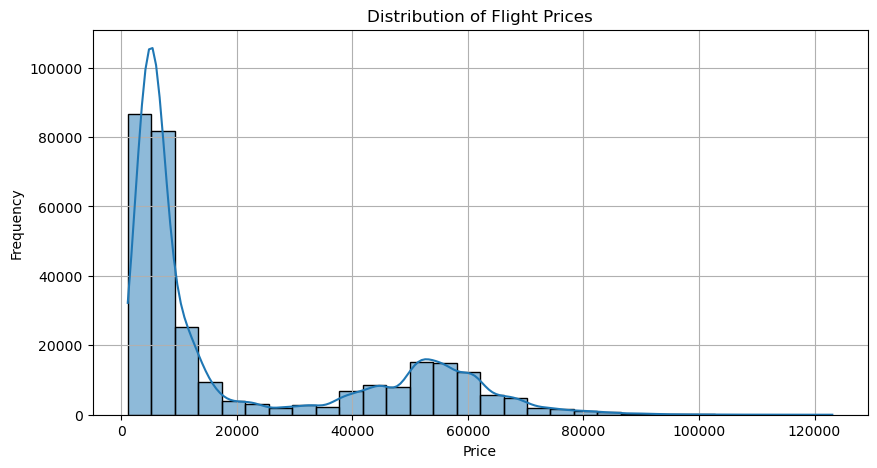

In [4]:
# Visualizing the distribution of flight prices
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Distribution of Flight Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid()
plt.show()

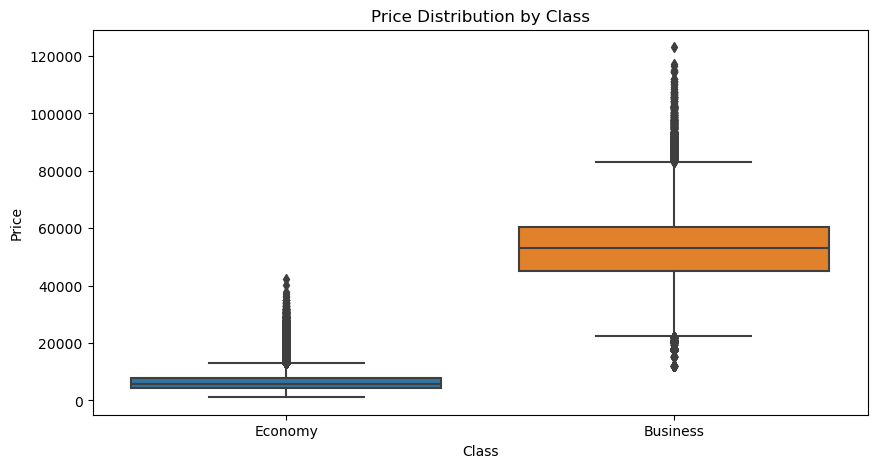

In [5]:
#Boxplot of Price by Class
plt.figure(figsize=(10, 5))
sns.boxplot(x='class', y='price', data=df)
plt.title('Price Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Price')
plt.show()

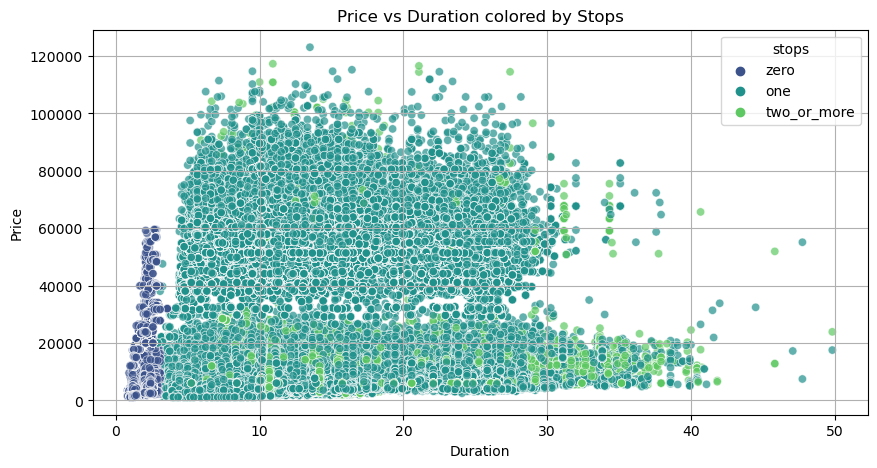

In [6]:
# Scatter Plot of Price vs. Duration
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='duration', y='price', hue='stops', palette='viridis', alpha=0.7)
plt.title('Price vs Duration colored by Stops')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.grid()
plt.show()


### Data Preprocessing

In [7]:
# Convert 'stops' column to numerical values if necessary
# Mapping additional string values like 'two_or_more' to numeric
stop_mapping = {
    'zero': 0,
    'one': 1,
    'two': 2,
    'three': 3,
    'two_or_more': 2  # Adjust as needed for other cases like 'two_or_more'
}
df['stops'] = df['stops'].replace(stop_mapping)

# Preparing the data for regression analysis
# Define features (X) and target variable (y)
X = df[['duration', 'stops', 'class']]
y = df['price']  # Target variable

# Feature Scaling: Standardize 'duration' feature
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X['duration'] = scaler.fit_transform(X[['duration']])

# Creating New Features
X['price_per_minute'] = y / (X['duration'] + 1e-5)  # Adding a small constant to avoid division by zero
X['is_nonstop'] = (X['stops'] == 0).astype(int)

# Handling Outliers
X['log_duration'] = np.log1p(df['duration'])
y_log = np.log1p(y)

# Encoding Categorical Variables
X = pd.get_dummies(X, columns=['class'], drop_first=True)

# Polynomial Features for 'duration' and 'stops'
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X[['duration', 'stops']])
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(['duration', 'stops']))

# Concatenate polynomial features with the rest of the features
X = pd.concat([X.reset_index(drop=True), X_poly.reset_index(drop=True)], axis=1)


C:\Users\zh wong\AppData\Local\Temp\ipykernel_9648\2721215568.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['duration'] = scaler.fit_transform(X[['duration']])
C:\Users\zh wong\AppData\Local\Temp\ipykernel_9648\2721215568.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['price_per_minute'] = y / (X['duration'] + 1e-5)  # Adding a small constant to avoid division by zero
C:\Users\zh wong\AppData\Local\Temp\ipykernel_9648\2721215568.py:24: SettingWithCopyWarning: 
A value is trying to be set on

### Train-Test Split

In [8]:
# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)


### Multiple Linear Regression

Multiple Linear Regression - MSE: 45833915.415339924
Multiple Linear Regression - RMSE: 6770.074993332048
Multiple Linear Regression - MAE: 4203.402488572471
Multiple Linear Regression - R^2: 0.9110853704085401


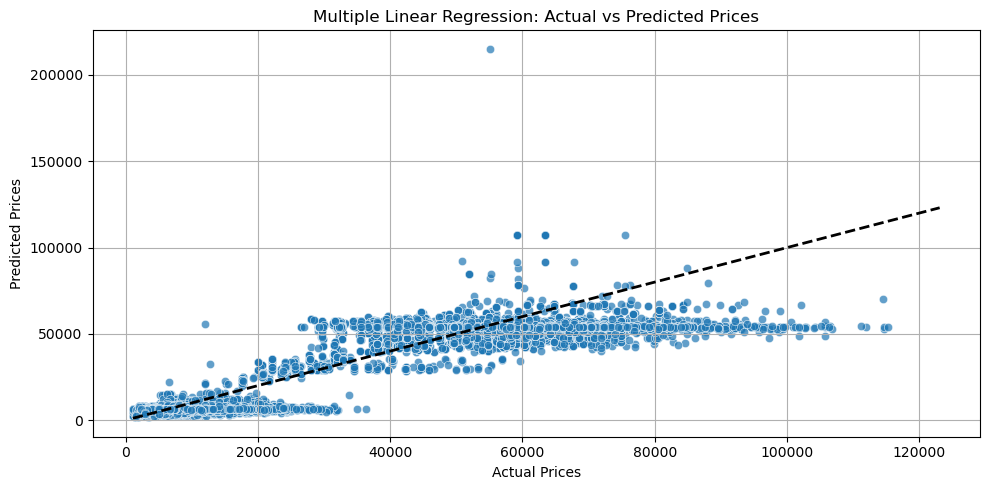

In [9]:
# Initialize the Multiple Linear Regression model
mlr = LinearRegression()

# Fit the model to the training data
mlr.fit(X_train, y_train)

# Predict on the test set and convert predictions back to the original scale
y_pred_log = mlr.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Calculate metrics including RMSE
mse = mean_squared_error(np.expm1(y_test), y_pred)
rmse = mean_squared_error(np.expm1(y_test), y_pred, squared=False) 
mae = mean_absolute_error(np.expm1(y_test), y_pred)
r2 = r2_score(np.expm1(y_test), y_pred)

# Print the performance metrics
print("Multiple Linear Regression - MSE:", mse)
print("Multiple Linear Regression - RMSE:", rmse)
print("Multiple Linear Regression - MAE:", mae)
print("Multiple Linear Regression - R^2:", r2)

# Plotting Actual vs Predicted for Multiple Linear Regression
plt.figure(figsize=(10, 5))
sns.scatterplot(x=np.expm1(y_test), y=y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Multiple Linear Regression: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid()
plt.tight_layout()
plt.show()

### Random Forest Regressor

Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Random Forest - MSE: 393870.8885453444
Random Forest - RMSE: 627.5913388068261
Random Forest - MAE: 97.34586647393958
Random Forest - R^2: 0.9992359176857462


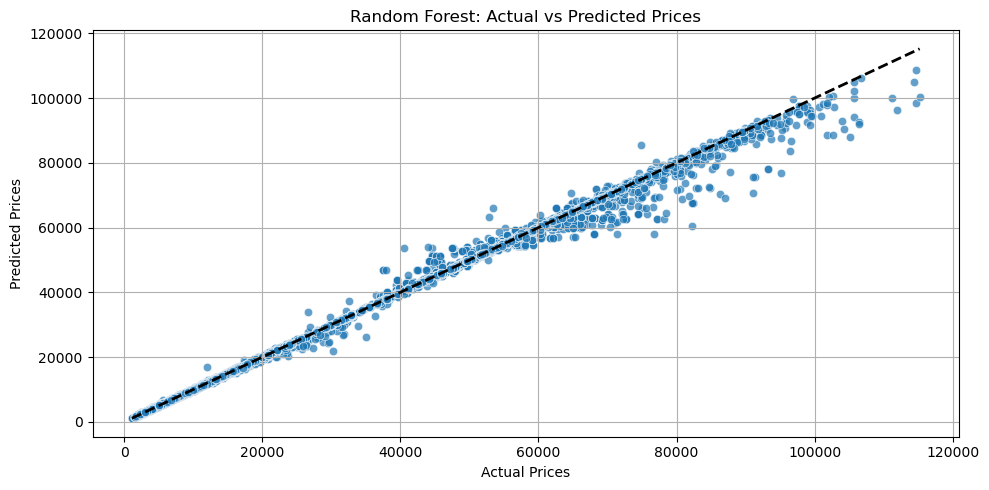

In [10]:
# Hyperparameter tuning for Random Forest Regressor
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, scoring='neg_mean_squared_error', n_iter=10, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Model Evaluation
best_rf_model = random_search.best_estimator_
rf_pred_log = best_rf_model.predict(X_test)
rf_pred = np.expm1(rf_pred_log)  # Transform back to original scale

# Calculate metrics for Random Forest
rf_mse = mean_squared_error(np.expm1(y_test), rf_pred)
rf_rmse = mean_squared_error(np.expm1(y_test), rf_pred, squared=False)  # Use rf_pred here
rf_mae = mean_absolute_error(np.expm1(y_test), rf_pred)
rf_r2 = r2_score(np.expm1(y_test), rf_pred)

print(f"Best parameters for Random Forest: {random_search.best_params_}")
print("Random Forest - MSE:", rf_mse)
print("Random Forest - RMSE:", rf_rmse)
print("Random Forest - MAE:", rf_mae)
print("Random Forest - R^2:", rf_r2)

# Plotting Actual vs Predicted for Random Forest
plt.figure(figsize=(10, 5))
sns.scatterplot(x=np.expm1(y_test), y=rf_pred, alpha=0.7)
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], 'k--', lw=2)
plt.title('Random Forest: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid()
plt.tight_layout()
plt.show()